In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.


References:
1. https://github.com/facebookresearch/segment-anything
2. https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb
3. https://github.com/openai/CLIP
4.https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb

# Automatically generating object masks with SAM and Classify masks with CLIP 

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

## Set-up

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from pkg_resources import packaging

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [121]:
image = cv2.imread('/content/R2202_02-10-2023_000000001.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

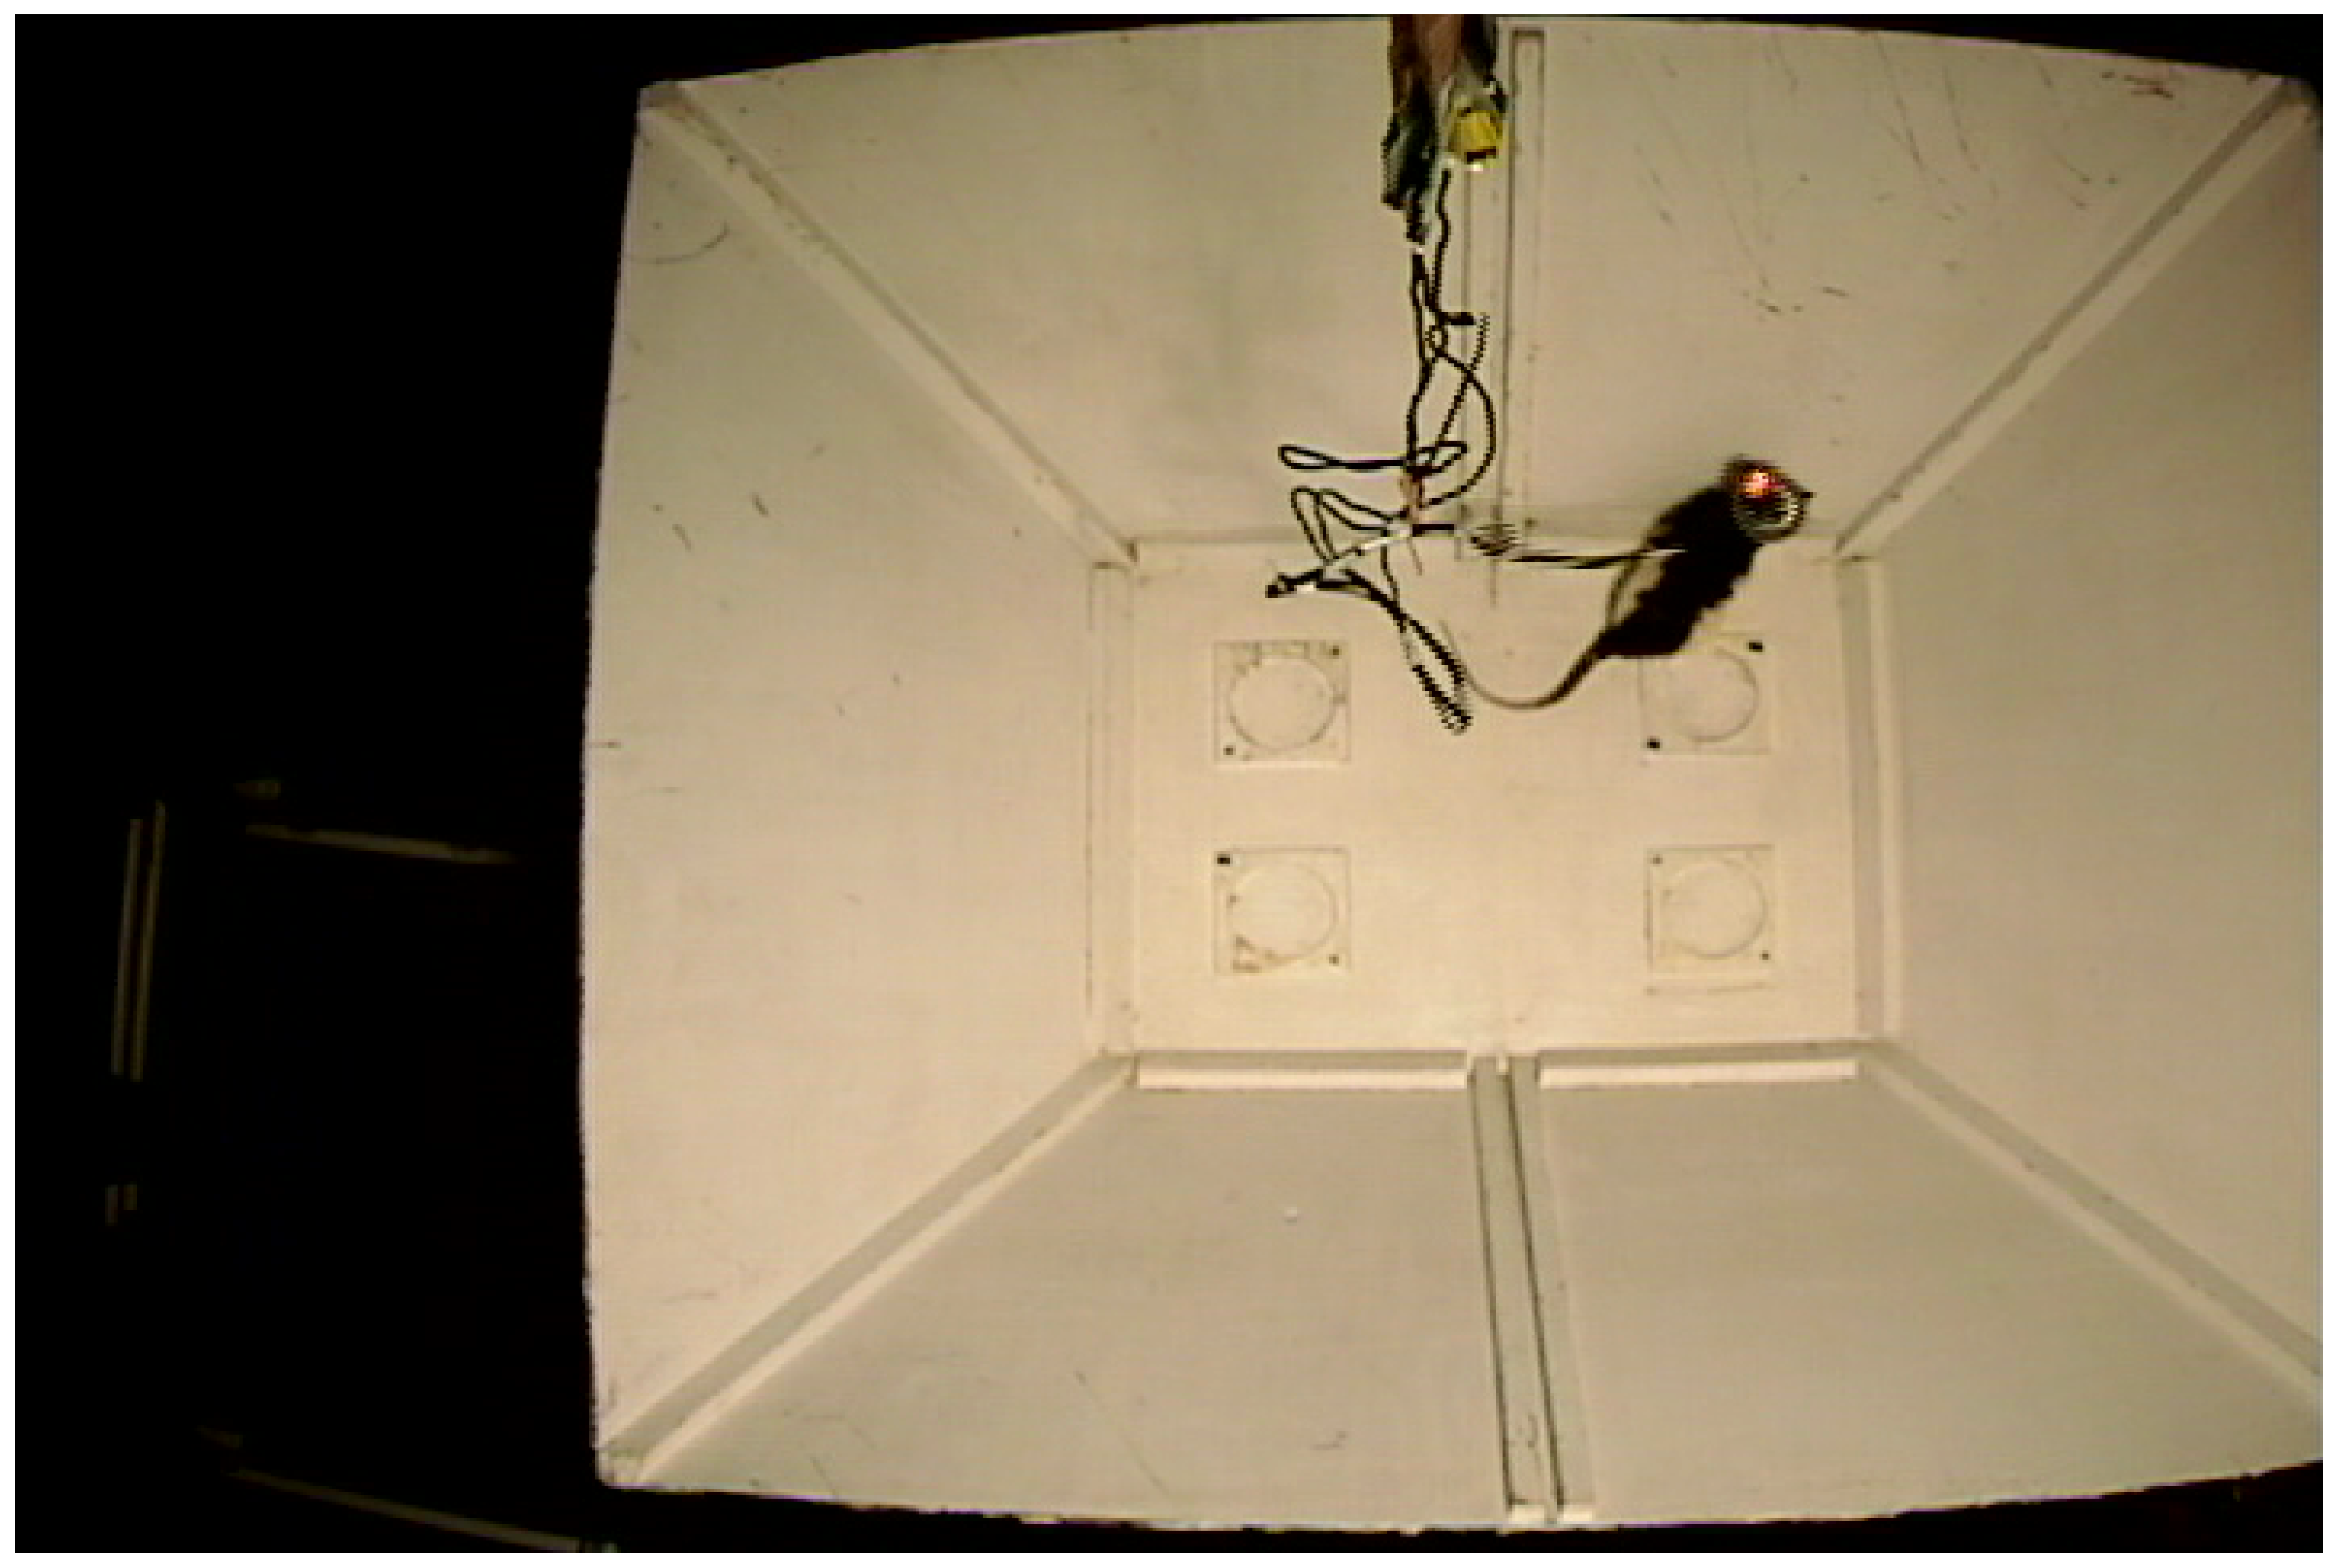

In [103]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [10]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [11]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [12]:
print(len(masks))
print(masks[0].keys())

28
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

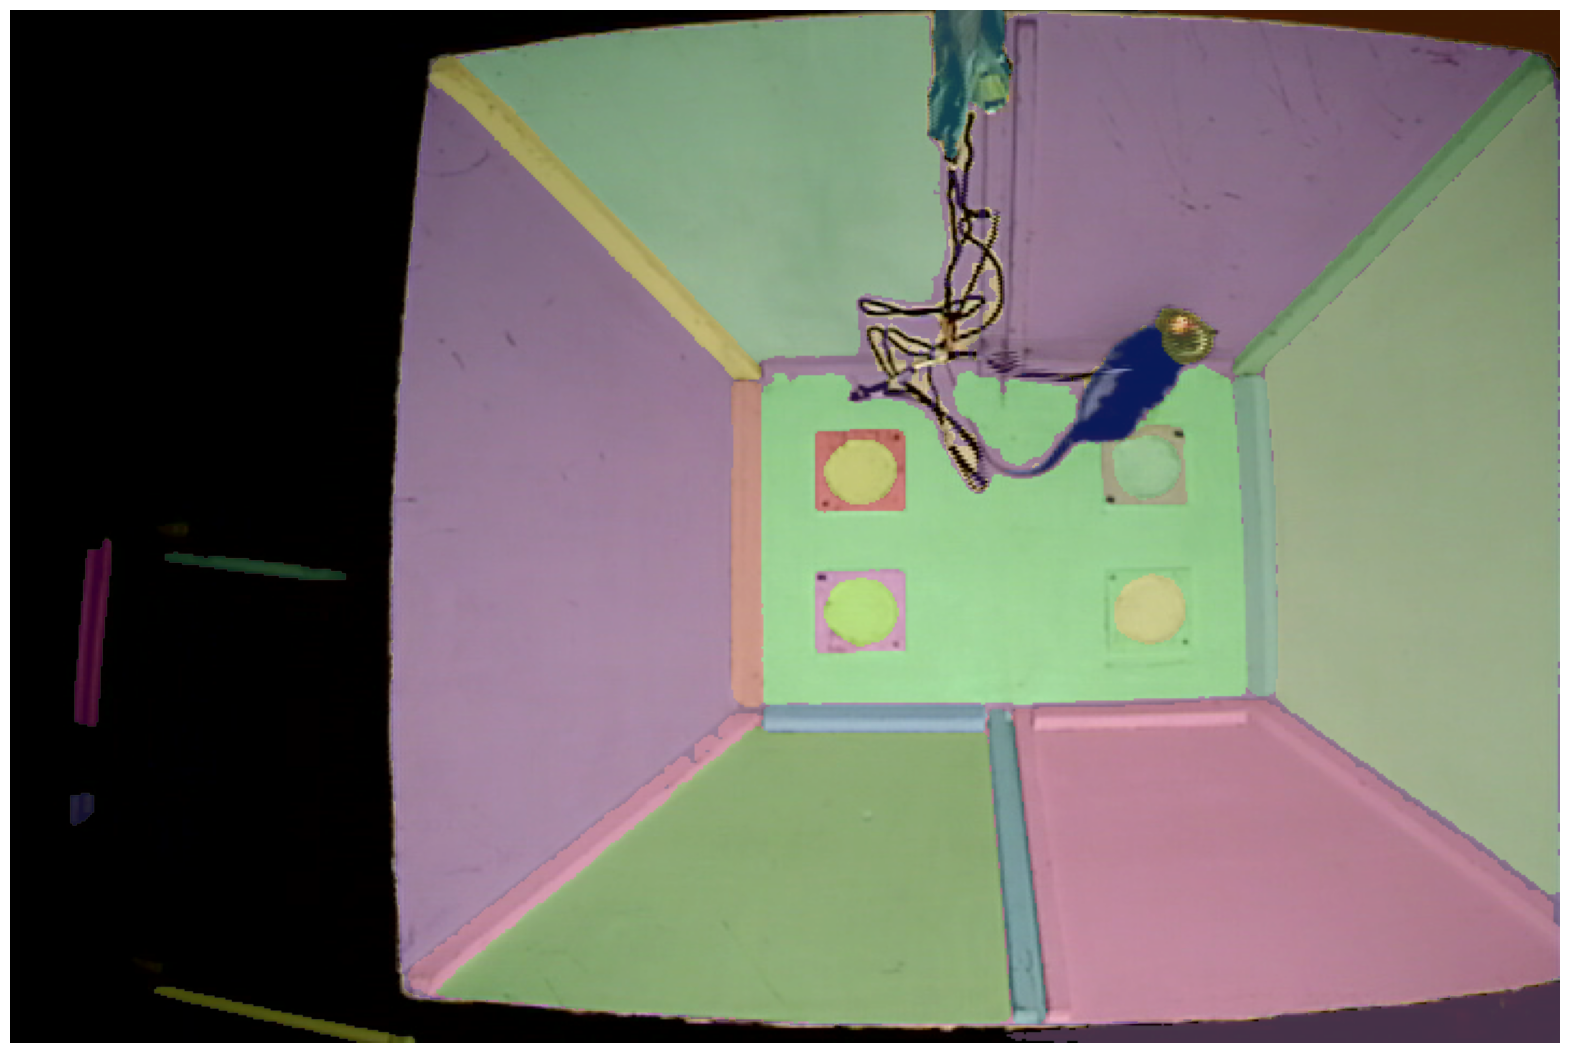

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [14]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [15]:
masks2 = mask_generator_2.generate(image)

In [16]:
len(masks2)

47

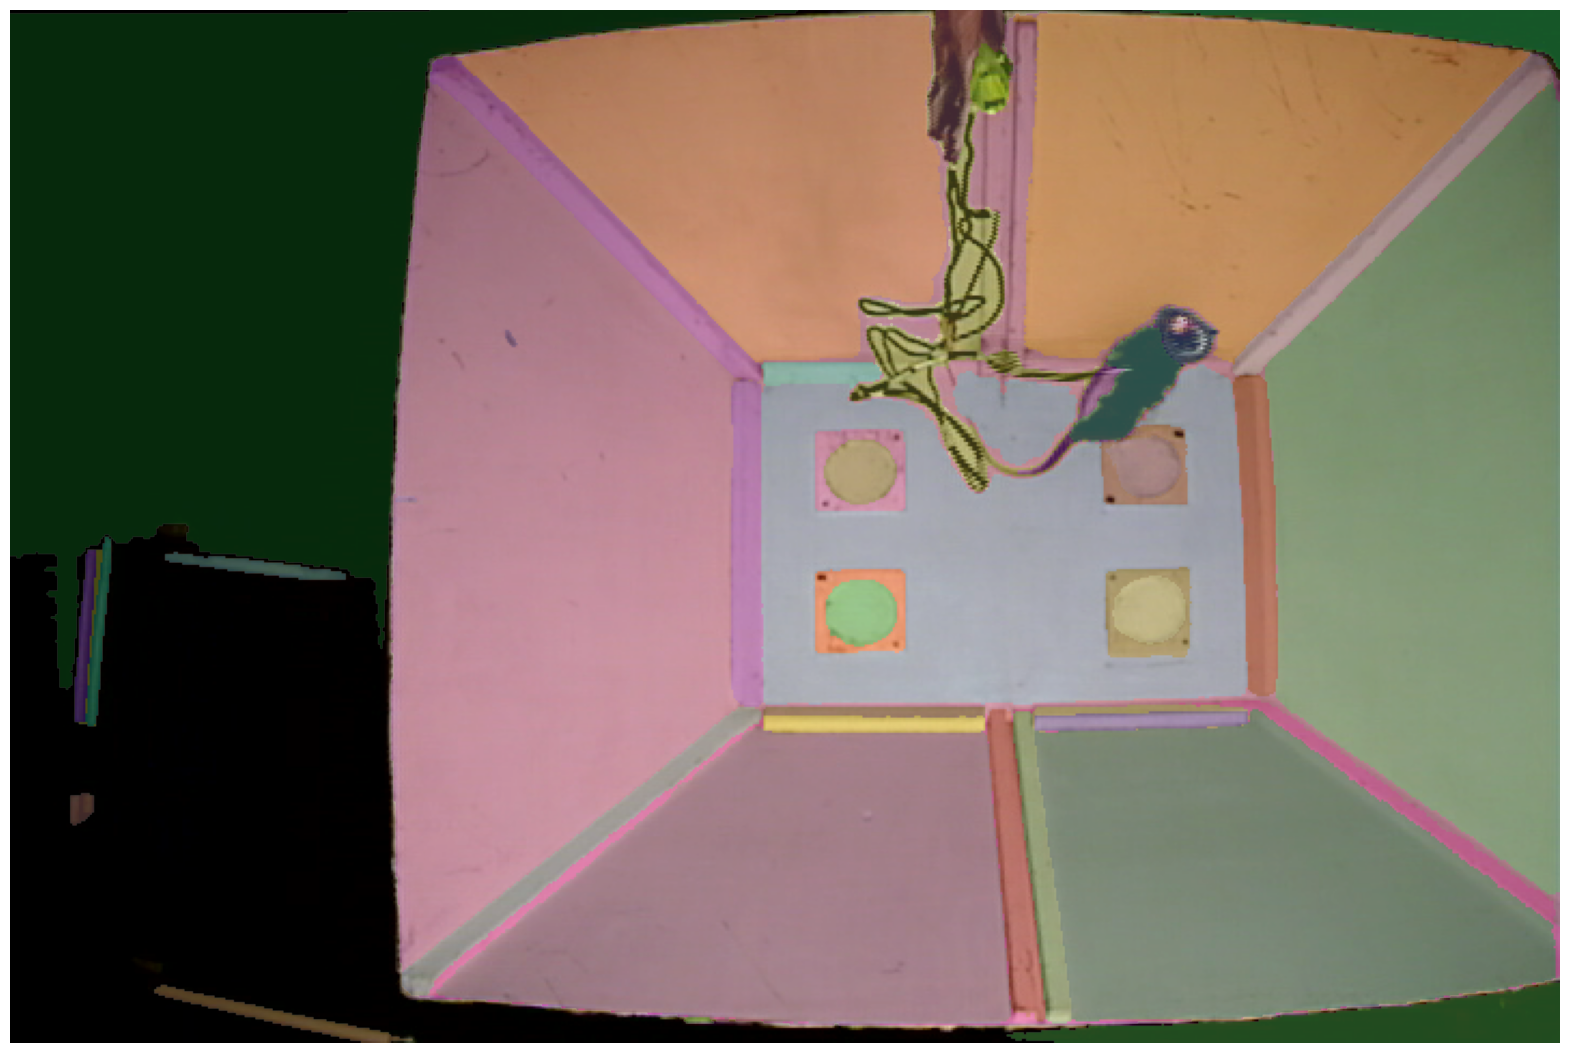

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [122]:
import numpy as np
import cv2

def crop_image_with_masks(image, masks):
    """
    Crop the image based on provided masks and apply the masks to each cropped region.

    Args:
        image (numpy.ndarray): The input image.
        masks (list): A list of dictionaries containing mask data.

    Returns:
        list: A list of cropped images with applied masks.
    """
    cropped_images = []

    for mask_data in masks:
        # Extract mask and bounding box data
        bbox = mask_data['bbox']
        seg = mask_data['segmentation']
        x, y, w, h = bbox

        # Crop the image based on the bounding box
        cropped_image = image[y:y+h, x:x+w]

        # Create an 8-bit mask from the segmentation data
        #mask = np.asarray(seg[y:y+h, x:x+w], dtype=np.uint8) * 255
        # Apply the mask to the cropped image
        #cropped_image = cv2.bitwise_and(cropped_image, cropped_image, mask=mask)
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

        cropped_images.append(cropped_image)

    return cropped_images

In [123]:
cropped_images = crop_image_with_masks(image,masks)

In [24]:
from google.colab.patches import cv2_imshow

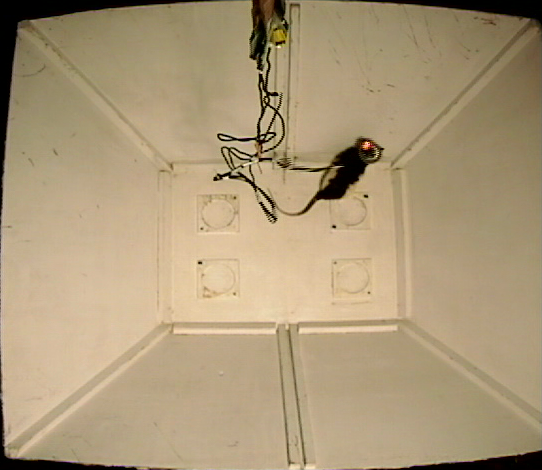

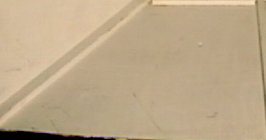

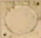

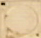

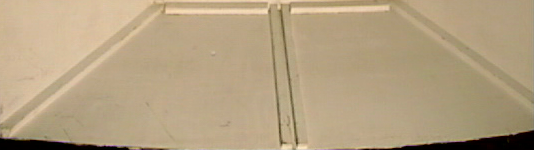

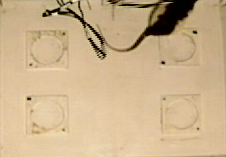

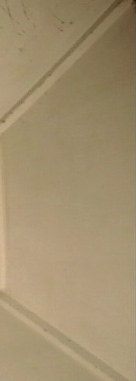

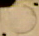

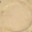

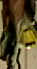

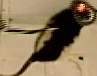

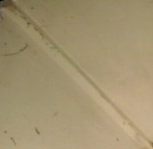

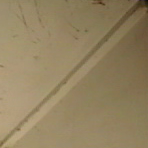

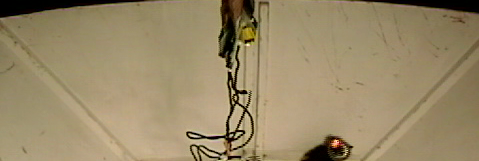

In [124]:
for cimg in cropped_images:
    cv2_imshow(cimg)

# Classify masks with openai/CLIP

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [26]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [27]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 64.6MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Setting up input images and texts

In [126]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images to use and their textual descriptions
descriptions = {
    "rat": "a black rat with a white stripe on its back",
    "wires": "electric wires",
    "box": "a box open on the top",
    "hand": "human hand",
    "arm": "human arm",
    "cup": "a cup filled with sand",
    "book": "a paper notebook",
    "vacuum": "a vacuum cleaner"
}

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.


In [127]:
class_names = list(descriptions.keys())
class_names

['rat', 'wires', 'box', 'hand', 'arm', 'cup', 'book', 'vacuum']

In [128]:
text_descriptions = [f"This is a photo of a {label}" for label in class_names]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [129]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [131]:
images = [preprocess(Image.fromarray(cimg)) for cimg in cropped_images]

In [132]:
image_input = torch.tensor(np.stack(images)).cuda()

In [133]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()


In [134]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [135]:
len(cropped_images)

28

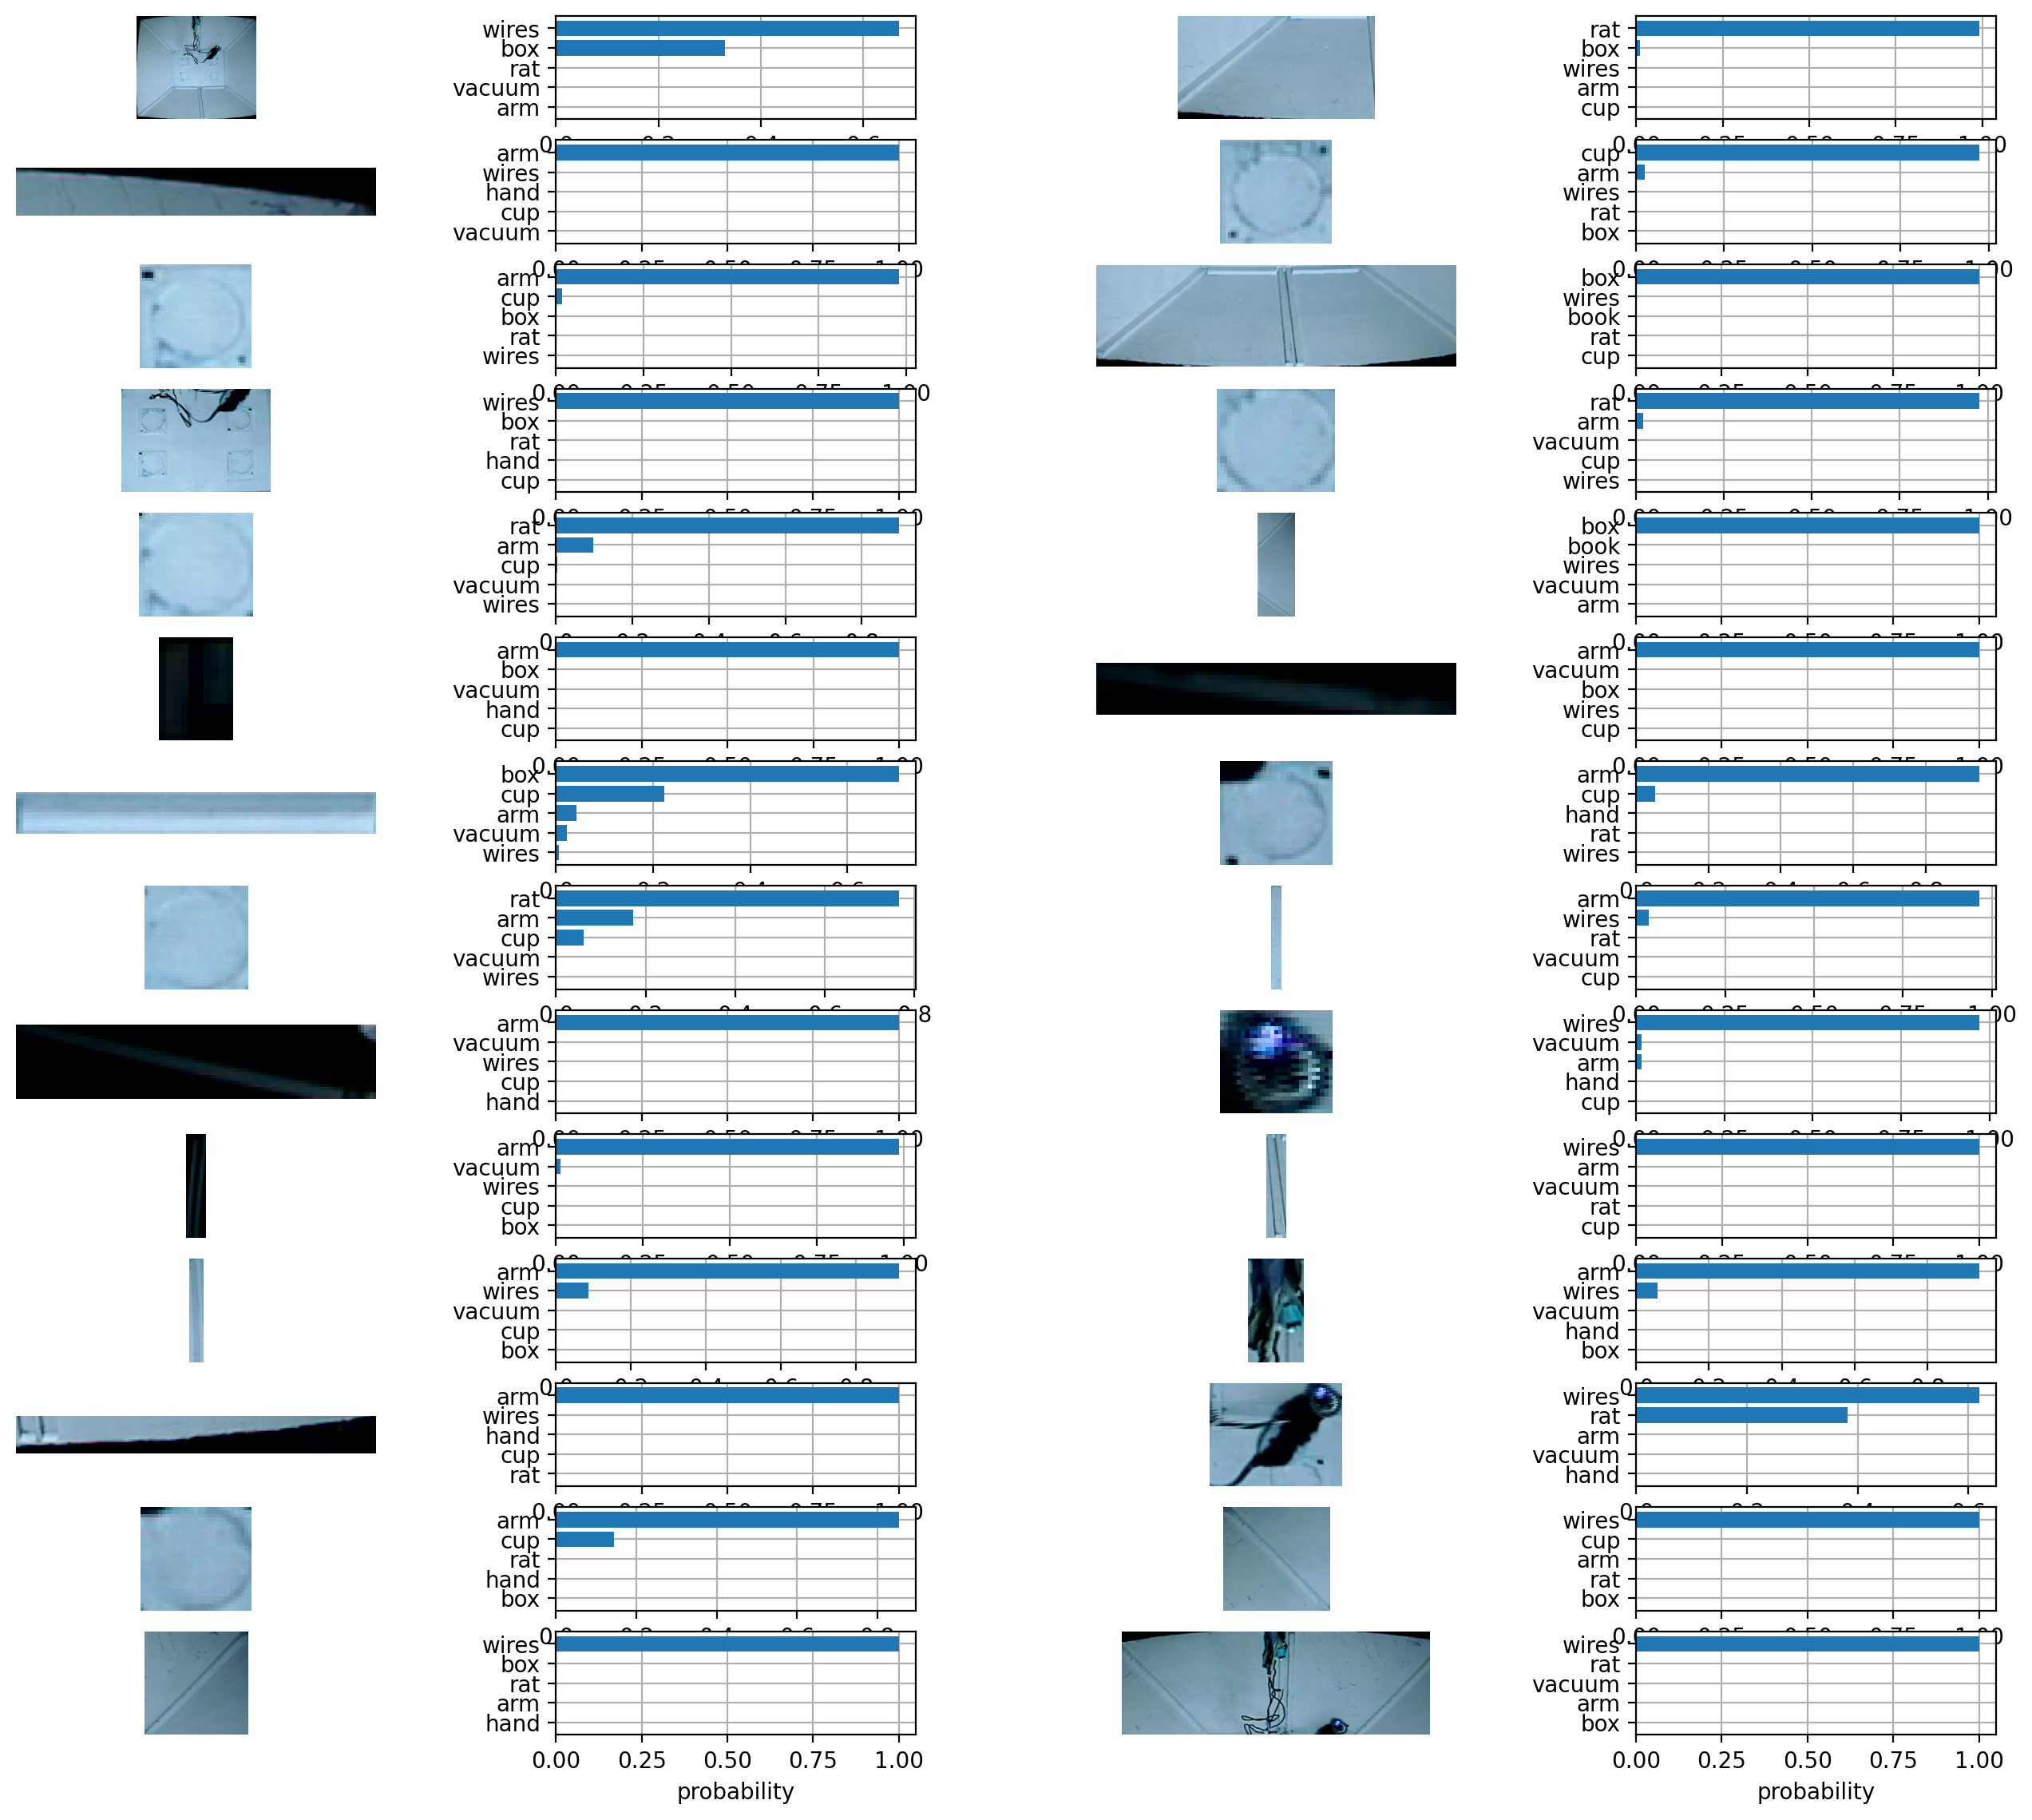

In [137]:
plt.figure(figsize=(16, 16))

for i, _image in enumerate(cropped_images):
    plt.subplot(16, 4, 2 * i + 1)
    plt.imshow(_image)
    plt.axis("off")

    plt.subplot(16, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [class_names[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()